## Step-by-step instructions to assemble HEST data 

This tutorial will guide you to convert a legacy Visium sample into a HEST-compatible object. 


### Download Visium sample from NCBI

In [ ]:
%%bash
# As an example, download the files from the following NCBI study:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6215674)

mkdir downloads
cd downloads
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6215nnn/GSM6215674/suppl/GSM6215674%5FS13.png.gz
gunzip GSM6215674_S13.png.gz
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6215nnn/GSM6215674/suppl/GSM6215674%5FS13%5Ffiltered%5Ffeature%5Fbc%5Fmatrix.h5

### Create HESTData object from the image and count matrix 

The library performs:

- Creation of AnnData object
- Creation of OpenSlide object 
- Automatic fiducial detection for spot alignment 

**Troubleshooting:**

If you encounter: `SystemError: ffi_prep_closure(): bad user_data (it seems that the version of the libffi library`. Attempt: `pip install --force-reinstall --no-binary :all: cffi`

/home/guillaume/anaconda3/envs/hest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


alignment file is  None


/home/guillaume/anaconda3/envs/hest/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/guillaume/anaconda3/envs/hest/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 1182 × 32298
    var: 'gene_ids', 'feature_types', 'genome'
trim the barcodes
no tissue_positions_list.csv/tissue_positions.csv or alignment file found
attempt fiducial auto alignment...

0: 608x640 1 filled_hexagon, 1 open_hexagon, 1 hourglass, 2 triangles, 96.2ms
Speed: 11.6ms preprocess, 96.2ms inference, 361.2ms postprocess per image at shape (1, 3, 608, 640)


/media/disk2/hest/hest/src/hest/autoalign.py:126: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circles2 = [plt.Circle(aligned_fiducials[i] * factor, radius=s_fid, color='r', facecolor='none', linewidth=0.3) for i in range(len(aligned_fiducials))]


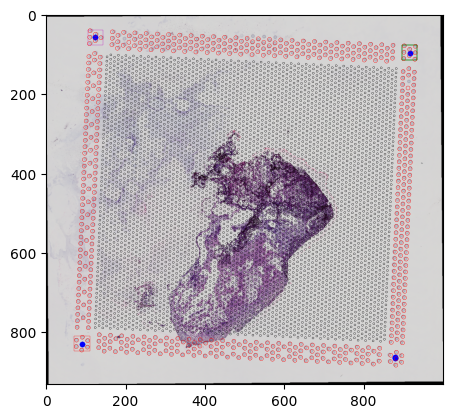

In [1]:
from hest import VisiumReader

fullres_img_path = 'downloads/GSM6215674_S13.png'
bc_matrix_path = 'downloads/GSM6215674_S13_filtered_feature_bc_matrix.h5'

st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    save_autoalign=True # pass this argument to visualize the fiducial autodetection
)

In [ ]:
st.save(path='processed')

You can also visualize an overlay of the aligned spots on the downscaled WSI

In [ ]:
st.save_spatial_plot(save_path='processed')

### When should I provide an alignment file and when should I use the autoalignment?

#### Step 1: check if a tissue_positions.csv/tissue_position_list.csv already provides a correct alignment

In most cases, if a `spatial/` folder containing a `tissue_positions.csv` or `tissue_position_list.csv` is available you don't need any autoalignment/alignment file.

Try the following:

`st = VisiumReader().read(fullres_img_path, bc_matric_path, spatial_coord_path=spatial_path)`, where `spatial_path` is contains `tissue_positions.csv` or `tissue_position_list.csv`. You can manually inspect the alignment by saving a visualization plot that takes the full resolution image, downscale it and overlays it with the spots (using `st.save_spatial_plot(save_dir)`). If the alignment is incorrect, try step 2.

#### Step 2: check if a .json alignment file is provided

If a `.json` alignment file is available, try: `VisiumReader().read(fullres_img_path, bc_matric_path, spatial_coord_path=spatial_path, alignment_file_path=align_path)`. You can also omit the `spatial_coord_path` as `VisiumReader().read(fullres_img_path, bc_matric_path, alignment_file_path=align_path)`

#### Step 3: attempt auto-alignment

If at least 3 corner fiducials are not cropped out and are reasonably visible, you can attempt an autoalignment with `VisiumReader().read(fullres_img_path, bc_matric_path`. (if no spatial folder and no alignment_file_path is provided, it will attempt autoalignment by default, you can also force auto-alignment by passing `autoalign='always'`). 

### Examples:

In [ ]:
from hest import VisiumReader

fullres_img_path = 'my_path/image.tif'
bc_matrix_path = 'my_path/filtered_bc_matrix.h5'
spatial_coord_path = 'my_path/spatial'
alignment_file_path = 'my_path/alignment.txt'

st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    spatial_coord_path=spatial_coord_path # path to a space ranger spatial/ folder containing either a tissue_positions.csv or tissue_position_list.csv
)

# if no spatial folder is provided, but you have an alignment file
st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    alignment_file_path=alignment_file_path # path to a .json alignment file
)

# if both the alignment file and the spatial folder are missing, attempt auto-alignment
st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
)


### Auto read
Given that `visium_dir` contains a full resolution image and all the necessary Visium files such as the `filtered_bc_matrix.h5` and the `spatial` folder, `VisiumReader.auto_read(path)` should be able to automatically read the sample. Prefer `read` for a more fine grain control.


In [ ]:
from hest import VisiumReader

visium_dir = ...

# attempt autoread
st = VisiumReader().auto_read(visium_dir)